In [2]:
from Fotomics import LogScaler,FftTransformer

/home/aj/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:

import pandas as pd
import numpy as np
import scanpy as sc

from scipy.spatial import ConvexHull
from matplotlib import pyplot as plt
import inspect
from numpy.fft import fft, fftshift
from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import seaborn as sns
import anndata as ad

In [4]:
expr_file = "data/GSE85217_with_Label.csv"

# Load data
df = pd.read_csv(expr_file, index_col=0)

# Ensure Label column is string (important if numeric)
df["Label"] = df["Label"].astype(str)

# Separate label and numeric data
labels = df["Label"]
X = df.drop(columns=["Label"])
X.columns = X.columns.astype(str)  # make sure var_names are strings

# Convert to AnnData
adata = ad.AnnData(X)
adata.obs["Label"] = labels.values

In [5]:
adata.obs

,Label
SampleID,
MB_SubtypeStudy_55001,SHH
MB_SubtypeStudy_55002,Group3
MB_SubtypeStudy_55003,Group4
MB_SubtypeStudy_55004,Group4
MB_SubtypeStudy_55005,Group4
...,...
MB_SubtypeStudy_55759,SHH
MB_SubtypeStudy_55760,SHH
MB_SubtypeStudy_55761,Group4


In [11]:

#expr_file = "data/Smartseq2_upperlim_gbm_data.h5ad"
#adata = sc.read_h5ad(expr_file)
# Convert sparse matrix to dense if needed
# Convert sparse matrix to dense if needed
X = adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X
y = adata.obs["Label"].values

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Check label distribution
labels_unique, labels_count = np.unique(y, return_counts=True)
print(labels_unique, labels_count)


['Group3' 'Group4' 'SHH' 'WNT'] [144 326 223  70]


In [12]:
# ---- Shuffle function ----
def shuffle_adata(adata, shuffle_rows=True, shuffle_cols=False):
    adata_shuffled = adata.copy()
    if shuffle_rows:
        row_perm = np.random.permutation(adata_shuffled.n_obs)
        adata_shuffled = adata_shuffled[row_perm, :]
    if shuffle_cols:
        col_perm = np.random.permutation(adata_shuffled.n_vars)
        adata_shuffled = adata_shuffled[:, col_perm]
    return adata_shuffled

# ---- Shuffle before splitting ----
adata = shuffle_adata(adata, shuffle_rows=True, shuffle_cols=False)

# ---- Convert sparse matrix to dense if needed ----
x = adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X
y = adata.obs["Label"].values

# ---- Train/test split ----
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, stratify=y, random_state=42
)


In [13]:
ln = LogScaler()

x_train_norm = ln.fit_transform(x_train)
x_test_norm = ln.transform(x_test)

/home/aj/Desktop/ComareModels/Fotomics_GSE85217_subtype/Fotomics.py:134: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_new[:, 0], x_new[:, 1], s=1,


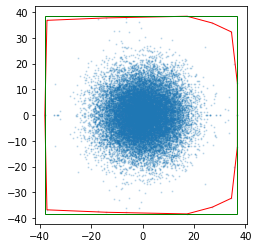

In [14]:
it = FftTransformer(pixels=124)
_ = it.fit(x_train_norm, plot=True)

In [15]:
x_train_img = it.transform(x_train_norm)
x_train_img.shape

(610, 124, 124, 3)

In [16]:
x_test_img = it.transform(x_test_norm)
x_test_img.shape

(153, 124, 124, 3)

Train img


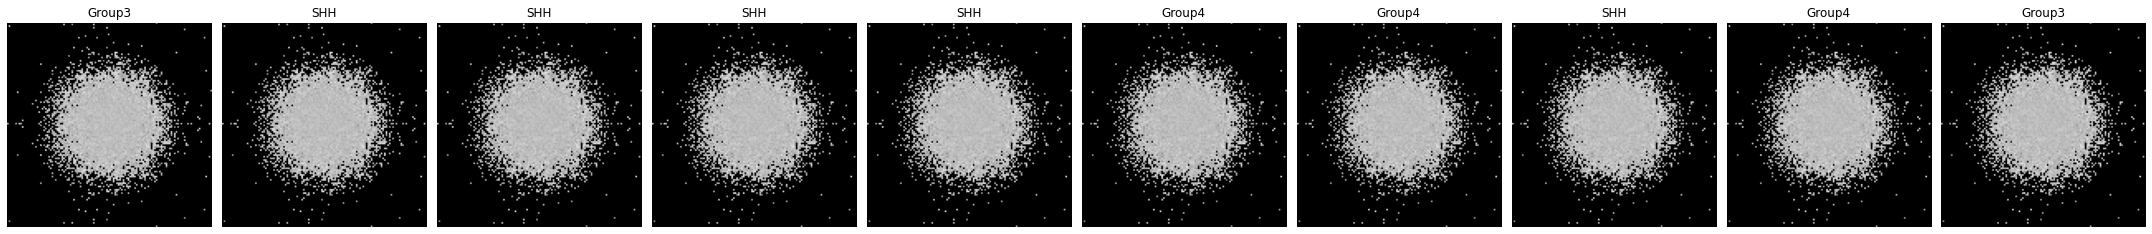

In [17]:
import matplotlib.pyplot as plt

print("Train img")

# Plot 10 images with tumor name titles
fig, axarr = plt.subplots(1, 10, figsize=(30, 4))---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
/tmp/ipykernel_27273/4212263356.py in <module>
      1 ln = LogScaler()
      2 
----> 3 x_train_norm = ln.fit_transform(x_train)
      4 x_test_norm = ln.transform(x_test)

NameError: name 'x_train' is not defined

for i in range(10):
    axarr[i].imshow(x_train_img[i])
    axarr[i].set_title(str(y_train[i]), fontsize=12)
    axarr[i].axis('off')

plt.tight_layout()
plt.show()



Test img


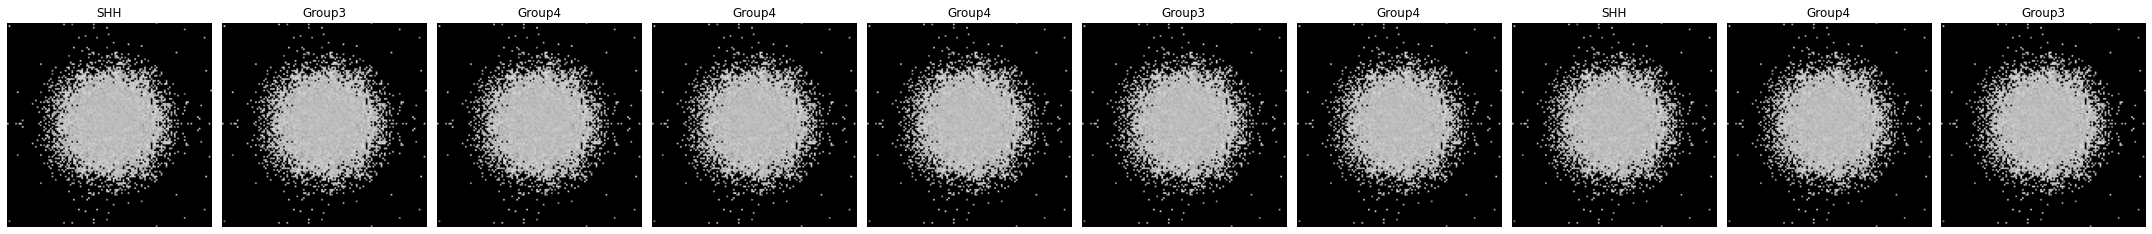

In [18]:
print("Test img")
f, axarr = plt.subplots(1, 10, figsize=(30, 4))

for i in range(10):   
    axarr[i].imshow(x_test_img[i])
    axarr[i].set_title(y_test[i])
    axarr[i].axis('off')

plt.tight_layout()
plt.show()


In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np


In [24]:
unique_classes = np.unique(np.concatenate([y_train, y_test]))
label = unique_classes.tolist()
label_to_index = {lbl: idx for idx, lbl in enumerate(label)}

y_new_train = np.array([label_to_index[y] for y in y_train], dtype=np.int64)
y_new_test = np.array([label_to_index[y] for y in y_test], dtype=np.int64)



In [25]:
df_y_train = torch.tensor(y_new_train, dtype=torch.long)  # no one-hot needed



In [26]:
print(x_train_img.shape)   # → (num_train_samples, 124, 124, 3)
print(df_y_train.shape)    # → (num_train_samples, num_classes)


(610, 124, 124, 3)
torch.Size([610])


In [27]:

class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 29 * 29, 64)  # calculated for 124x124 input
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))  # -> [batch, 64, 61, 61]
        x = self.pool2(F.relu(self.conv2(x)))  # -> [batch, 64, 29, 29]
        x = self.flatten(x)                    # -> [batch, 64*29*29]
        x = F.relu(self.fc1(x))                 # -> [batch, 64]
        return self.fc2(x)                      # raw logits

In [28]:
X_train_tensor = torch.tensor(x_train_img.transpose(0, 3, 1, 2), dtype=torch.float32)
y_train_tensor = torch.tensor(y_new_train, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Validation split (80/20)
val_size = int(0.2 * len(train_dataset))
train_size = len(train_dataset) - val_size
train_ds, val_ds = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel(num_classes=len(label)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=8, factor=0.1)

best_val_loss = float('inf')
patience = 10
patience_counter = 0

for epoch in range(90):
    model.train()
    total_loss, correct = 0, 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (outputs.argmax(1) == y_batch).sum().item()

    train_loss = total_loss / len(train_loader)
    train_acc = correct / len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            val_correct += (outputs.argmax(1) == y_batch).sum().item()

    val_loss /= len(val_loader)
    val_acc = val_correct / len(val_loader.dataset)

    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
          f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

    # Scheduler and Early Stopping
    scheduler.step(val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save best model
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Load best model for evaluation
model.load_state_dict(torch.load('best_model.pth'))


Epoch 1: Train Loss=1.3236, Train Acc=0.3852, Val Loss=1.2786, Val Acc=0.4016
Epoch 2: Train Loss=1.2602, Train Acc=0.4344, Val Loss=1.2799, Val Acc=0.4016
Epoch 3: Train Loss=1.2682, Train Acc=0.4160, Val Loss=1.2787, Val Acc=0.4016
Epoch 4: Train Loss=1.2588, Train Acc=0.4344, Val Loss=1.2767, Val Acc=0.4016
Epoch 5: Train Loss=1.2588, Train Acc=0.4344, Val Loss=1.2677, Val Acc=0.4016
Epoch 6: Train Loss=1.2665, Train Acc=0.4344, Val Loss=1.2697, Val Acc=0.4016
Epoch 7: Train Loss=1.2544, Train Acc=0.4344, Val Loss=1.2964, Val Acc=0.4016
Epoch 8: Train Loss=1.2833, Train Acc=0.4344, Val Loss=1.2728, Val Acc=0.4016
Epoch 9: Train Loss=1.2649, Train Acc=0.4344, Val Loss=1.2688, Val Acc=0.4016
Epoch 10: Train Loss=1.2591, Train Acc=0.4344, Val Loss=1.2693, Val Acc=0.4016
Epoch 11: Train Loss=1.2630, Train Acc=0.4344, Val Loss=1.2715, Val Acc=0.4016
Epoch 12: Train Loss=1.2618, Train Acc=0.4344, Val Loss=1.2934, Val Acc=0.4016
Epoch 13: Train Loss=1.2616, Train Acc=0.4344, Val Loss=1.262

<All keys matched successfully>

In [30]:
X_test_tensor = torch.tensor(x_test_img.transpose(0, 3, 1, 2), dtype=torch.float32)
y_test_tensor = torch.tensor(y_new_test, dtype=torch.long)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32)


In [31]:
model.eval()
test_correct, test_loss = 0, 0.0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item()
        test_correct += (outputs.argmax(1) == y_batch).sum().item()

test_loss /= len(test_loader)
test_acc = test_correct / len(test_loader.dataset)

print(f"Test Loss={test_loss:.4f}, Test Acc={test_acc:.4f}")


Test Loss=0.0670, Test Acc=0.9608


In [32]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt


In [33]:
model.eval()
all_preds = []

with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = outputs.argmax(1).cpu().numpy()
        all_preds.extend(preds)

y_pred = np.array(all_preds)
y_true = y_new_test  # from earlier


In [34]:
from torch.utils.data import DataLoader, TensorDataset

# Build loader with batch inference to avoid OOM
train_dataset_eval = TensorDataset(X_train_tensor, y_train_tensor)
train_loader_eval = DataLoader(train_dataset_eval, batch_size=32)

model.eval()
train_preds = []

with torch.no_grad():
    for X_batch, _ in train_loader_eval:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = outputs.argmax(1).cpu().numpy()
        train_preds.extend(preds)

train_accuracy = accuracy_score(y_new_train, train_preds)


In [35]:
# Get y_score (logits) from model in batches
y_score = []

model.eval()
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        y_score.append(outputs.detach().cpu().numpy())  # detach() for safety

y_score = np.vstack(y_score)  # shape: (n_samples, n_classes)



In [36]:
from sklearn.preprocessing import label_binarize
from scipy.special import softmax

# Convert logits to probabilities
y_prob = softmax(y_score, axis=1)

# Binarize true labels
y_true_bin = label_binarize(y_true, classes=np.arange(len(label)))

# Compute ROC-AUC
roc_auc_macro = roc_auc_score(y_true_bin, y_prob, average='macro', multi_class='ovo')
roc_auc_weighted = roc_auc_score(y_true_bin, y_prob, average='weighted', multi_class='ovo')



Training Accuracy: 0.9868852459016394
Test Accuracy: 0.9607843137254902
Precision (Macro): 0.9590120663650075
Precision (Micro): 0.9607843137254902
Precision (Weighted): 0.9616192982974988
Recall (Macro): 0.9561155319776009
Recall (Micro): 0.9607843137254902
Recall (Weighted): 0.9607843137254902
F1-score (Macro): 0.9564445526129084
F1-score (Micro): 0.9607843137254902
F1-score (Weighted): 0.9603375865546552
ROC-AUC (OvO, Macro): 0.9992539510947643
ROC-AUC (OvO, Weighted): 0.9992575538148568

Classification Report:
               precision    recall  f1-score   support

      Group3       0.96      0.86      0.91        29
      Group4       0.94      0.98      0.96        65
         SHH       1.00      0.98      0.99        45
         WNT       0.93      1.00      0.97        14

    accuracy                           0.96       153
   macro avg       0.96      0.96      0.96       153
weighted avg       0.96      0.96      0.96       153



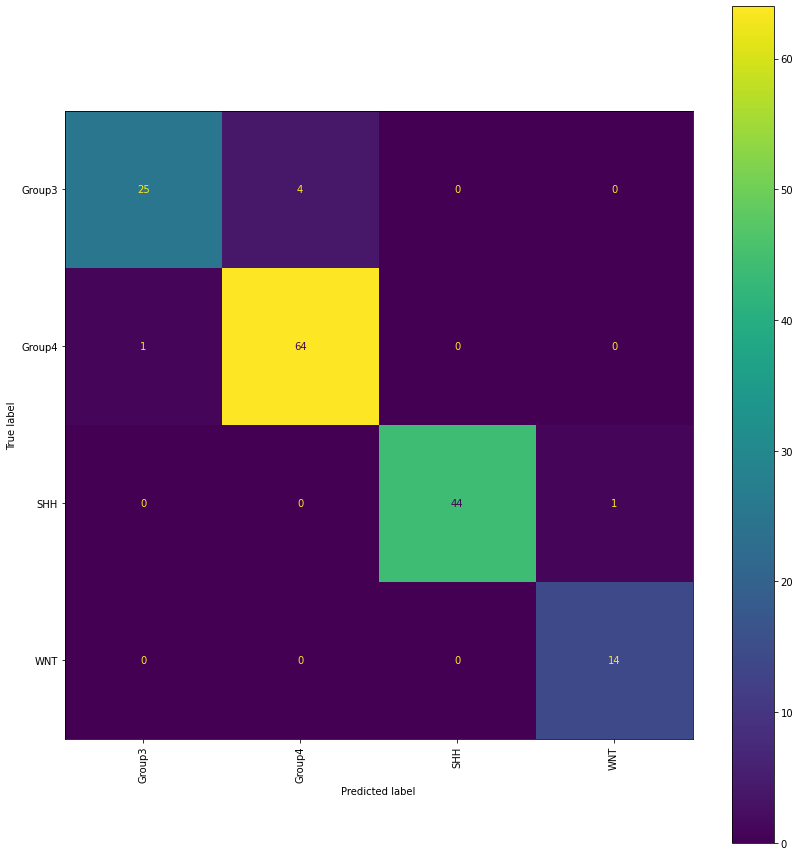

In [37]:
from sklearn.metrics import (
    classification_report, accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, ConfusionMatrixDisplay
)
from sklearn.preprocessing import label_binarize
from scipy.special import softmax
import matplotlib.pyplot as plt
import numpy as np

# Compute accuracies
train_accuracy = accuracy_score(y_new_train, train_preds)
test_accuracy = accuracy_score(y_true, y_pred)

# Precision
precision_macro = precision_score(y_true, y_pred, average='macro')
precision_micro = precision_score(y_true, y_pred, average='micro')
precision_weighted = precision_score(y_true, y_pred, average='weighted')

# Recall
recall_macro = recall_score(y_true, y_pred, average='macro')
recall_micro = recall_score(y_true, y_pred, average='micro')
recall_weighted = recall_score(y_true, y_pred, average='weighted')

# F1-score
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_micro = f1_score(y_true, y_pred, average='micro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

# ROC-AUC
y_prob = softmax(y_score, axis=1)
y_true_bin = label_binarize(y_true, classes=np.arange(len(label)))
roc_auc_macro = roc_auc_score(y_true_bin, y_prob, average='macro', multi_class='ovo')
roc_auc_weighted = roc_auc_score(y_true_bin, y_prob, average='weighted', multi_class='ovo')

# Classification report
report = classification_report(y_true, y_pred, target_names=label)

# Print metrics
print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print("Precision (Macro):", precision_macro)
print("Precision (Micro):", precision_micro)
print("Precision (Weighted):", precision_weighted)
print("Recall (Macro):", recall_macro)
print("Recall (Micro):", recall_micro)
print("Recall (Weighted):", recall_weighted)
print("F1-score (Macro):", f1_macro)
print("F1-score (Micro):", f1_micro)
print("F1-score (Weighted):", f1_weighted)
print("ROC-AUC (OvO, Macro):", roc_auc_macro)
print("ROC-AUC (OvO, Weighted):", roc_auc_weighted)
print("\nClassification Report:\n", report)

# Confusion matrix
fig, ax = plt.subplots(figsize=(12, 12))
ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred, display_labels=label, ax=ax, xticks_rotation=90
)
plt.tight_layout()
plt.show()

